<a href="https://colab.research.google.com/github/jx-dohwan/KoELECTRA_MRC/blob/main/KoELECTRA_MRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting

In [1]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.3 MB/s eta 0:00:00


In [2]:
import os
import json
import numpy 
import matplotlib.pyplot as plt

In [13]:
import argparse
import glob
import logging
import os
import random
import timeit

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

import transformers
from transformers import (
    MODEL_FOR_QUESTION_ANSWERING_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    squad_convert_examples_to_features,
)
from transformers.data.metrics.squad_metrics import (
    compute_predictions_log_probs,
    compute_predictions_logits,
    squad_evaluate,
)
from transformers.data.processors.squad import SquadResult, SquadV1Processor, SquadV2Processor
from transformers.trainer_utils import is_main_process


In [3]:
from transformers import ElectraModel, ElectraTokenizer

model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Data Preprocessing

### 1. 원본 데이터 탐색
- 데이터 다운로드
  - KorQuAD 1.0 데이터 (https://korquad.github.io/KorQuad%201.0/) 에서 Training set, Dev set 다운로드 후 Google Drive에 업로드
- 데이터 구성
  - 1,560 개의 Wikipedia article에 대해 10,645 건의 문단과 66,181 개의 질의응답 쌍
  - Training set 60,407 개, Dev set 5,774 개의 질의응답쌍

In [4]:
DATAPATH = "/content/drive/MyDrive/인공지능/질의응답/data/korquad"  
filenames = [x for x in os.listdir (DATAPATH) if x.endswith('json')]
filenames.sort()
filenames

['KorQuAD_v1.0_dev.json', 'KorQuAD_v1.0_train.json']

In [5]:
file = filenames[1]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

In [6]:
data[0]

{'paragraphs': [{'qas': [{'answers': [{'text': '교향곡', 'answer_start': 54}],
     'id': '6566495-0-0',
     'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'},
    {'answers': [{'text': '1악장', 'answer_start': 421}],
     'id': '6566495-0-1',
     'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?'},
    {'answers': [{'text': '베토벤의 교향곡 9번', 'answer_start': 194}],
     'id': '6566495-0-2',
     'question': '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?'},
    {'answers': [{'text': '파우스트', 'answer_start': 15}],
     'id': '6566518-0-0',
     'question': '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?'},
    {'answers': [{'text': '합창교향곡', 'answer_start': 354}],
     'id': '6566518-0-1',
     'question': '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?'},
    {'answers': [{'text': '1839', 'answer_start': 0}],
     'id': '5917067-0-0',
     'question': '바그너가 파우스트를 처음으로 읽은 년도는?'},
    {'answers': [{'text': '파리', 'answer_start': 410}],
     'id': '5917067-0-1',
     'question': '바그너가 처음 교향곡 작곡을 한 장소는?'},
    {'answers': [{'text': '드레스덴', 'answer_sta

## EDA

### Train

In [7]:
file = filenames[1]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

In [8]:
cont_lens = []
q_lens = []
a_lens = []

para_num = 0
cont_num = 0
q_num = 0

cont_unk_num = 0
q_unk_num = 0
a_unk_num = 0

for x in range(len(data)):
  paragraphs = data[x]['paragraphs']
  para_num += 1

  # context
  for para in paragraphs:
    context = para['context']
    cont_num += 1
    con_tokens = tokenizer.tokenize(context)
    cont_lens.append(len(con_tokens))

    for t in con_tokens:
      if t == ['UNK']:
        cont_unk_num += 1

    # qas
    qas = para['qas']
    for qa in qas:
      question = qa['question']
      answer = qa['answers'][0]['text']
      q_num += 1
      q_tokens  = tokenizer.tokenize(question)
      a_tokens = tokenizer.tokenize(answer)
      q_lens.append(len(q_tokens))
      a_lens.append(len(a_tokens))

      for t in q_tokens:
        if t == '[UNK]':
          q_unk_num += 1
      
      for t in a_tokens:
        if t == '[UNK]':
          a_unk_num += 1

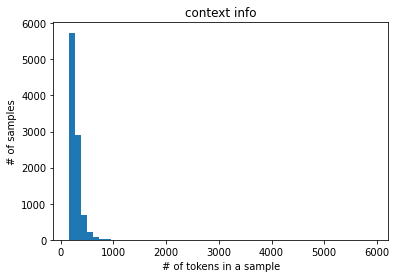

-------------------------context info-----------------------------
# of paragraphs = 1420 | # of contexts = 9681
min = 147 | mean = 274.51 | median = 245.00 | max = 5925
# of [UNK] tokens = 0 | % of [UNK] tokens = 0.00%


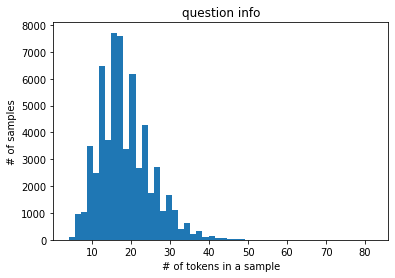

--------------- question info ---------------
# of questions = 60407
min = 4 | mean = 18.46 | median = 18.00 | max = 82
# of [UNK] tokens = 110 | % of [UNK] tokens = 0.01%


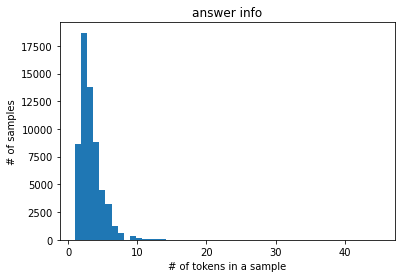

--------------- answer info ---------------
# of answers = 60407
min = 1 | mean = 3.12 | median = 3.00 | max = 45
# of [UNK] tokens = 109 | % of [UNK] tokens = 0.06%


In [9]:
# context
min = numpy.min(cont_lens)
mean = numpy.mean(cont_lens)
median = numpy.median(cont_lens)
max = numpy.max(cont_lens)

plt.hist(cont_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('context info')
plt.show()

print('-------------------------context info-----------------------------')
print('# of paragraphs = {} | # of contexts = {}'.format(para_num, cont_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(cont_unk_num, 100*(cont_unk_num/sum(cont_lens))))

#question
min = numpy.min(q_lens)
mean = numpy.mean(q_lens)
median = numpy.median(q_lens)
max = numpy.max(q_lens)

plt.hist(q_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('question info')
plt.show()

print('--------------- question info ---------------')
print('# of questions = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(q_unk_num, 100*(q_unk_num/sum(q_lens))))

#answer
min = numpy.min(a_lens)
mean = numpy.mean(a_lens)
median = numpy.median(a_lens)
max = numpy.max(a_lens)

plt.hist(a_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('answer info')
plt.show()

print('--------------- answer info ---------------')
print('# of answers = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(a_unk_num, 100*(a_unk_num/sum(a_lens))))

### Dev

In [10]:
file = filenames[0]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

In [11]:
cont_lens = []
q_lens = []
a_lens = []

para_num = 0
cont_num = 0
q_num = 0

cont_unk_num = 0
q_unk_num = 0
a_unk_num = 0

for x in range(len(data)):
  paragraphs = data[x]['paragraphs']
  para_num += 1

  # context
  for para in paragraphs:
    context = para['context']
    cont_num += 1
    con_tokens = tokenizer.tokenize(context)
    cont_lens.append(len(con_tokens))

    for t in con_tokens:
      if t == ['UNK']:
        cont_unk_num += 1

    # qas
    qas = para['qas']
    for qa in qas:
      question = qa['question']
      answer = qa['answers'][0]['text']
      q_num += 1
      q_tokens  = tokenizer.tokenize(question)
      a_tokens = tokenizer.tokenize(answer)
      q_lens.append(len(q_tokens))
      a_lens.append(len(a_tokens))

      for t in q_tokens:
        if t == '[UNK]':
          q_unk_num += 1
      
      for t in a_tokens:
        if t == '[UNK]':
          a_unk_num += 1

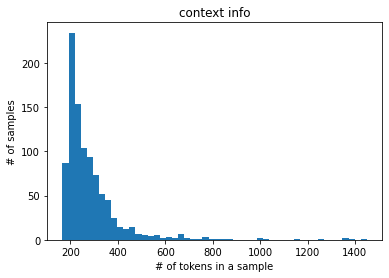

-------------------------context info-----------------------------
# of paragraphs = 140 | # of contexts = 964
min = 166 | mean = 284.69 | median = 244.50 | max = 1450
# of [UNK] tokens = 0 | % of [UNK] tokens = 0.00%


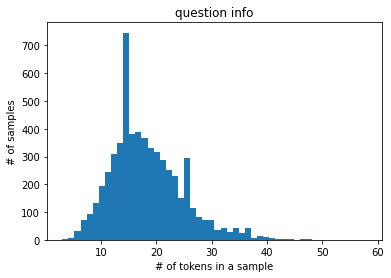

--------------- question info ---------------
# of questions = 5774
min = 3 | mean = 18.19 | median = 17.00 | max = 58
# of [UNK] tokens = 9 | % of [UNK] tokens = 0.01%


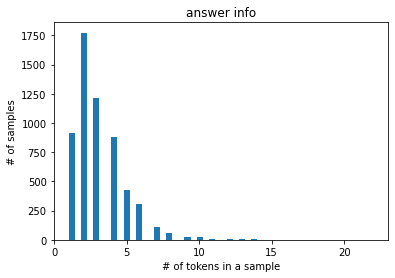

--------------- answer info ---------------
# of answers = 5774
min = 1 | mean = 3.08 | median = 3.00 | max = 22
# of [UNK] tokens = 10 | % of [UNK] tokens = 0.06%


In [12]:
# context
min = numpy.min(cont_lens)
mean = numpy.mean(cont_lens)
median = numpy.median(cont_lens)
max = numpy.max(cont_lens)

plt.hist(cont_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('context info')
plt.show()

print('-------------------------context info-----------------------------')
print('# of paragraphs = {} | # of contexts = {}'.format(para_num, cont_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(cont_unk_num, 100*(cont_unk_num/sum(cont_lens))))

#question
min = numpy.min(q_lens)
mean = numpy.mean(q_lens)
median = numpy.median(q_lens)
max = numpy.max(q_lens)

plt.hist(q_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('question info')
plt.show()

print('--------------- question info ---------------')
print('# of questions = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(q_unk_num, 100*(q_unk_num/sum(q_lens))))

#answer
min = numpy.min(a_lens)
mean = numpy.mean(a_lens)
median = numpy.median(a_lens)
max = numpy.max(a_lens)

plt.hist(a_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('answer info')
plt.show()

print('--------------- answer info ---------------')
print('# of answers = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(a_unk_num, 100*(a_unk_num/sum(a_lens))))

### 3. Feature 생성

In [14]:
def load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=False):
    if args.local_rank not in [-1, 0] and not evaluate:
        # Make sure only the first process in distributed training process the dataset, and the others will use the cache
        torch.distributed.barrier()

    # Load data features from cache or dataset file
    input_dir = args.data_dir if args.data_dir else "."
    cached_features_file = os.path.join(
        input_dir,
        "cached_{}_{}_{}".format(
            "dev" if evaluate else "train",
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            str(args.max_seq_length),
        ),
    )

    # Init features and dataset from cache if it exists
    if os.path.exists(cached_features_file) and not args.overwrite_cache:
        logger.info("Loading features from cached file %s", cached_features_file)
        features_and_dataset = torch.load(cached_features_file)
        features, dataset, examples = (
            features_and_dataset["features"],
            features_and_dataset["dataset"],
            features_and_dataset["examples"],
        )
    else:
        logger.info("Creating features from dataset file at %s", input_dir)

        if not args.data_dir and ((evaluate and not args.predict_file) or (not evaluate and not args.train_file)):
            try:
                import tensorflow_datasets as tfds
            except ImportError:
                raise ImportError("If not data_dir is specified, tensorflow_datasets needs to be installed.")

            if args.version_2_with_negative:
                logger.warning("tensorflow_datasets does not handle version 2 of SQuAD.")

            tfds_examples = tfds.load("squad")
            examples = SquadV1Processor().get_examples_from_dataset(tfds_examples, evaluate=evaluate)
        else:
            processor = SquadV2Processor() if args.version_2_with_negative else SquadV1Processor()
            if evaluate:
                examples = processor.get_dev_examples(args.data_dir, filename=args.predict_file)
            else:
                examples = processor.get_train_examples(args.data_dir, filename=args.train_file)

        features, dataset = squad_convert_examples_to_features(
            examples=examples,
            tokenizer=tokenizer,
            max_seq_length=args.max_seq_length,
            doc_stride=args.doc_stride,
            max_query_length=args.max_query_length,
            is_training=not evaluate,
            return_dataset="pt",
            threads=args.threads,
        )

        if args.local_rank in [-1, 0]:
            logger.info("Saving features into cached file %s", cached_features_file)
            torch.save({"features": features, "dataset": dataset, "examples": examples}, cached_features_file)

    if args.local_rank == 0 and not evaluate:
        # Make sure only the first process in distributed training process the dataset, and the others will use the cache
        torch.distributed.barrier()

    if output_examples:
        return dataset, examples, features
    return dataset

## Training
- 하이퍼파라미터 설정
  - model_type
    - transformers의 MODEL_FOR_QUESTION_ANSWERING_MAPPING 목록에 있는 모델 종류 중 선택
    - 'albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'bloom', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'flaubert', 'fnet', 'funnel', 'gptj', 'ibert', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'longformer', 'mbart', 'megatron-bert', 'mobilebert', 'reformer', 'rembert', 'roberta', 'roformer', 'splinter', 'squeezebert', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'yoso’ 등
  - model_name_or_path
    - 사전 학습 모델 경로 혹은 huggingface.co/models에 업로드 된 model idenfitier
  - output_dir
    - 모델의 checkpoint 및 prediction 파일 저장 경로
  - data_dir
    - 데이터셋 경로. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - train_file
    - 학습 파일. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - predict_file
    - 평가 파일. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - config_name
    - model_name과 동일하지 않을 시 설정하는 config 이름 혹은 경로
  - tokenizer_name
    - model_name과 동일하지 않을 시 설정하는 tokenizer 이름 혹은 경로
  - cache_dir
    - huggingface.co에서 다운로드한 사전 학습 모델 저장 경로
  - version_2_with_negative
    - no-answer 포함하는 데이터셋일 경우 true로 설정
  - null_score_diff_threshold
    - null_score - best_non_null이 prediction null의 threshold보다 큰 경우
  - max_seq_length
    - WordPiece로 토크나이징 후 input sequence의 길이. max_seq_length보다 길면 truncate, 짧으면 padding
  - doc_stride
    - 긴 문서를 chunk로 분할할 때 chunk 사이에 겹치는 토큰 수 (stride)
  - max_query_length
    - 질문 토큰의 최대 길이. max_query_length보다 길면 truncate
  - do_train
    - 학습 여부
  - do_eval
    - 평가 여부
  - evaluate_during_training
    - 학습 시 logging step마다 평가 여부
  - do_lower_case
    - uncased 모델일 경우 설정. 한국어 모델은 uncased 모델
  - per_gpu_train_batch_size
    - 학습 시 batch size
  - per_gpu_eval_batch_size
    - 평가 시 batch size
  - learning_rate
    - Adam optimizer의 초기 learning rate
gradient_accumulation_steps
    - backward/update pass 시 쌓을 steps 수
batch size가 커서 OOM 에러가 발생할 때, mini-batch를 통해 구해진 gradient를 global gradient에 누적시킨 후 한번에 update
    - 예: batch_size = 16, gradient_accumulation_steps = 16 이면 batch _size = 256의 효과이나 학습 시간이 매우 길어짐
  - weight_decay
    - overfitting을 막기 위한 weight decay
  - adam_epsilon
    - Adam optimizer의 epsilon 값
  - max_grad_norm
    - grandient clipping을 위한 max gradient norm
  - num_train_epochs
    - 학습 epoch 수
  - max_steps
    - 학습 step 수. 0보다 크면 num_train_epochs을 상속받음.
  - warmup_steps
    - linear warmup 을 위한 step 수
  - n_best_size
    - nbest_prediction.json 파일을 통해 생성되는 n-best prediction의 개수
  - max_answer_length
    - 생성할 수 있는 최대 정답의 길이
  - verbose_logging
    - true로 설정 시 데이터 전처리 시 발생하는 warning 모두 출력
  - lang_id
    - language-specific xlm 모델을 위한 값. (ELECTRA와는 상관 없음)
  - logging_steps
    - n step 마다 로그 작성
  - save_steps
    - n step 마다 checkpoint 저장
  - eval_all_checkpoints
    - 모든 checkpoint 평가 여부
  - no_cuda
    - true로 설정 시 GPU 사용하지 않음
  - overwrite_output_dir
    - output 디렉토리 overwrite 여부
  - overwrite_cache
    - cache 파일 overwrite 여부
  - seed
    - 초기화를 위한 random seed
  - local_rank
    - GPU 분산 학습을 위한 local rank
  - fp16
    - NVIDIA apex를 통해 계산량을 줄이기 위한 목적으로 single(fp32)와 half(fp16)를 섞은 mixed precision 사용 여부
    - master weigth를 fp32에서 fp16로 변환한 후 back/forward propagatio은 fp16로 연산 수행. 이후 weight update 시 다시 fp32
  - fp16_opt_level
    - Apex AMP optimization
  - server_ip
    - distant debugging을 위해 사용
  - server_port
    - distant debugging을 위해 사용
  - threads
    - example에서 feature 생성할 때 사용할 multiple threads